<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#EDA-анализ" data-toc-modified-id="EDA-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EDA анализ</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Dummy" data-toc-modified-id="Dummy-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dummy</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>BERT</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» BERT-

**ОПИСАНИЕ ЗАДАЧИ**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import numpy as np
import pandas as pd

import re
from string import punctuation # библиотека знаков пунктуации для фунции лемматизации
import nltk
from nltk.corpus import stopwords as nltk_stopwords 
# nltk.download('wordnet')
# nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, vstack, csc_matrix, csr_matrix, coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

from lightgbm.sklearn import LGBMClassifier

import torch
import transformers
from tqdm import notebook

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# настройки окружения
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {'axes.grid' : True}) # задает темный фон и сетку на графиках
pd.set_option('display.max_colwidth', 100, 'colheader_justify', 'left', 'precision', 4)

## Подготовка

In [3]:
# копирование датасета и настроек в локал
# !cp /datasets/ds_bert/vocab.txt vocab.txt
# !cp /datasets/ds_bert/bert_config.json bert_config.json
# !cp /datasets/ds_bert/rubert_model.bin rubert_model.bin

In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv', encoding='UTF-8')

In [5]:
df.head().style.set_properties(subset=['text'],**{'text-align': 'left'})

,text,toxic
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
# максимальное число слов в ячейке датасета
pd.concat([df['toxic'], df['text'].str.count(' ') + 1], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.1017,0.3022,0.0,0.0,0.0,0.0,1.0
text,159571.0,67.8670,100.5202,1.0,17.0,36.0,76.0,2273.0


**В датасете около 10% токсичных комментариев**, большинство текстов имеет длину 36 слов, но есть и целые "опусы" на  2 273 слова.

In [8]:
############################################
# изменение порядка столбцов, для удобства
df = df[['toxic', 'text']] 
############################################

**Вывод: пропусков нет, дополнительная предобработка данных не требуется.**

### EDA анализ 

Первая гипотеза для проверки - связь длины комментария с его токсичностью. Предположительно такие комментарии будут более короткими чем обычные. 

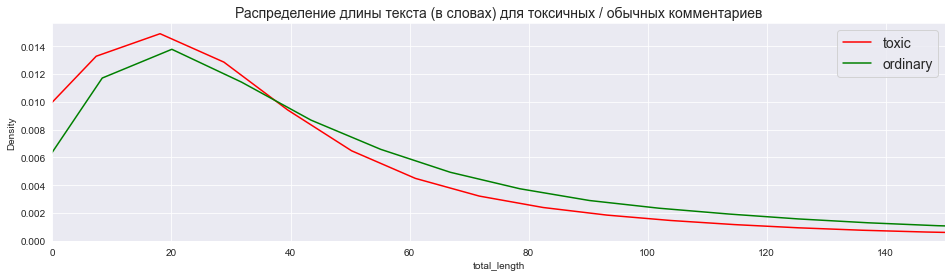

In [9]:
df['total_length'] = df['text'].str.count(' ') + 1
plt.figure(figsize=(16, 4))
plt.title('Распределение длины текста (в словах) для токсичных / обычных комментариев', fontsize=14)
sns.kdeplot(df.loc[df['toxic']==1, 'total_length'], color='red', alpha=0.7)
sns.kdeplot(df.loc[df['toxic']==0, 'total_length'], color='green')
plt.legend(['toxic', 'ordinary'], fontsize=14)
plt.xlim(0, 150);

Разница в длине текста есть, но довольно незначительная. В качестве дальнейшего развития идеи список признаков заимствован из статьи "How I improved my text classification model with feature engineering / Advanced text analysis to improve your model accuracy" https://towardsdatascience.com/how-i-improved-my-text-classification-model-with-feature-engineering-98fbe6c13ef3

In [10]:
# функция для создания новых признаков
def feature(df, text_columns) :
    df['word_count'] = df[text_columns].apply(lambda x : len(x.split()))
    df['char_count'] = df[text_columns].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)
    df['punc_count'] = df[text_columns].apply(lambda x : len([a for a in x if a in punctuation]))
    df['total_length'] = df[text_columns].apply(len)
    df['capitals'] = df[text_columns].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] =df[text_columns].apply(lambda x: x.count('!'))
    df['num_question_marks'] = df[text_columns].apply(lambda x: x.count('?'))
    df['num_punctuation'] = df[text_columns].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    df['num_symbols'] = df[text_columns].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    df['num_unique_words'] = df[text_columns].apply(lambda x: len(set(w for w in x.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
    df["word_unique_percent"] =  df["num_unique_words"]*100/df['word_count']
    return df

In [11]:
# создание новых признаков
feature(df, 'text');

In [12]:
# проверка результата
df.head(2).style.set_properties(subset=['text'], **{'text-align': 'left', 'min-width': '400px'})

,toxic,text,total_length,word_count,char_count,word_density,punc_count,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words,words_vs_unique,word_unique_percent
0,0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",264,43,223,0.1920,10,17,0.0644,0,1,6,0,41,0.9535,95.3488
1,0,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",112,17,95,0.1771,12,8,0.0714,1,0,5,0,17,1.0000,100.0000


In [13]:
# проверка разброса значений признаков
df.describe().transpose()[['mean', 'max']]

,mean,max
toxic,0.1017,1.0000
total_length,394.0732,5000.0000
word_count,67.2735,1411.0000
char_count,327.2063,4967.0000
word_density,0.2088,0.9655
punc_count,15.8854,4942.0000
capitals,17.1596,4960.0000
caps_vs_length,0.0516,0.9982
num_exclamation_marks,0.6616,4942.0000
num_question_marks,0.4493,209.0000


По многим параметрам видны значительные **выбросы**, например для `num_exclamation_marks` при среднем 0.66 max=4942, поэтому в качестве предобработки была проведена винсоризацию, с заменой значений выше 95 перцентиля на значением 95 перцентиля, однако эффекта ни в качестве, ни в скорости обучения модели это не дало и от такой обработки решено отказаться.

In [14]:
# список признаков для винсоризации
#df.columns
features_columns = ['total_length', 'word_count', 'char_count',
       'word_density', 'punc_count', 'capitals', 'caps_vs_length',
       'num_exclamation_marks', 'num_question_marks', 'num_punctuation',
       'num_symbols', 'num_unique_words', 'words_vs_unique',
       'word_unique_percent']

In [15]:

# # функция винсоризации и обработка признаков по 95 перцентилю
# def vinsorization(series, percentile=95):
#     percent_value = np.percentile(series, percentile)
#     series.loc[series > percent_value] =  percent_value

# for column in features_columns:
#     vinsorization(df[column])    

Проводим анализ полученных признаков в разрезе среднее для токсичных/обычных текстов, относительная разница в показателях между ними и на **наличие выбросов в полученных данных:**
- max, максимальное значение показателя датасете (после винсоризации по 95 перцентилю)
- perc_95, значение 95 перцентиля

**сравнительные показатели:**
- d_normalized округленный до целого размер дельты между показателем токсичного и обычного текста - 1 ед. эквивалент 10% разнице в средних)


In [16]:
df_features_result = df.groupby(by='toxic').mean().transpose()
df_features_result['bigger'] = df_features_result.apply(lambda x: x[0] if x[0] > x[1] else x[1], axis=1)
df_features_result['perc_95'] = df[df_features_result.index].apply(lambda x: np.percentile(x, 95), axis=0)
df_features_result['max'] = df[df_features_result.index].max()
df_features_result['delta_%'] = np.abs(df_features_result[0] / df_features_result[1] - 1) * 100
# добавляются нормализованиие по уровню 10 данные для построения диаграммы "радар"
df_features_result['0_normalized'] = np.rint(df_features_result[0] / df_features_result['bigger'] * 10)
df_features_result['1_normalized'] = np.rint(df_features_result[1] / df_features_result['bigger'] * 10)
df_features_result['d_normalized'] = np.rint(df_features_result['delta_%'] / 10)
# сортировка и проверка
df_features_result = df_features_result.sort_values(by='delta_%', ascending=False)
df_features_result

toxic,0,1,bigger,perc_95,max,delta_%,0_normalized,1_normalized,d_normalized
num_exclamation_marks,0.3434,3.4727,3.4727,2.0000,4942.0000,90.1103,1.0,10.0,9.0
capitals,14.2370,42.9808,42.9808,49.0000,4960.0000,66.8759,3.0,10.0,7.0
caps_vs_length,0.0449,0.1110,0.1110,0.1250,0.9982,59.5659,4.0,10.0,6.0
num_unique_words,49.7809,33.2231,49.7809,146.0000,816.0000,49.8382,10.0,7.0,5.0
num_punctuation,8.2017,5.9636,8.2017,26.0000,682.0000,37.5299,10.0,7.0,4.0
char_count,335.8147,251.1515,335.8147,1124.0000,4967.0000,33.7100,10.0,7.0,3.0
total_length,404.3472,303.3040,404.3472,1355.0000,5000.0000,33.3141,10.0,8.0,3.0
word_count,68.9211,52.7177,68.9211,230.0000,1411.0000,30.7361,10.0,8.0,3.0
num_question_marks,0.4336,0.5880,0.5880,2.0000,209.0000,26.2685,7.0,10.0,3.0
num_symbols,0.1143,0.1418,0.1418,0.0000,148.0000,19.3464,8.0,10.0,2.0


In [17]:
# #код рабочий, но поскольку plotly не сохраняет в Jupyter рисунок, ниже вставлена картинка

# fig = px.line_polar(df_features_result, 
#                     r= df_features_result.loc[columns_features_best, 'd_normalized'].values,
#                     theta=columns_features_best, line_close=True,
#                     title='Уровень отличий признаков токсичного и обычного текста (больше - сильнее)')
# fig.update_traces(fill='toself')
# fig.show()

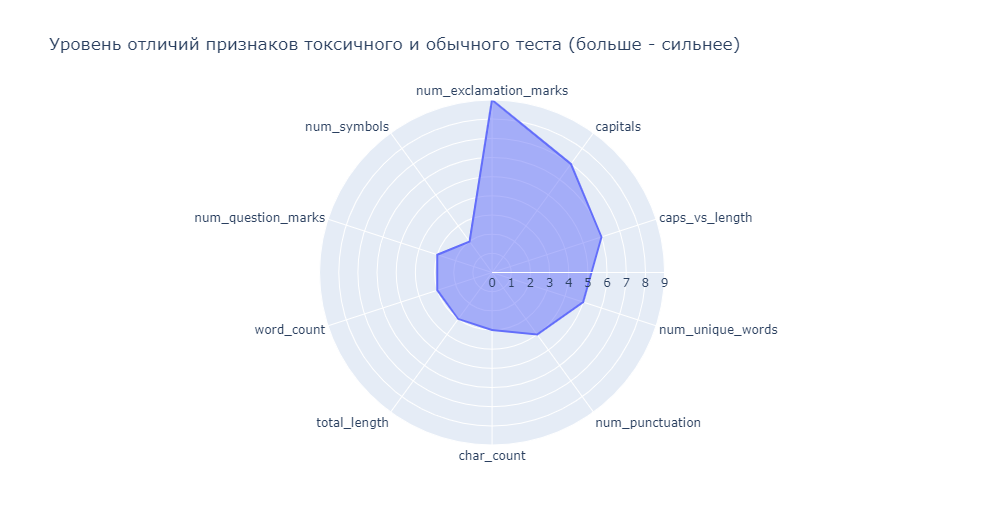

**Вывод** есть несколько признаков существенно больших для токсичных текстов: числовые восклицания!!!, чрезмерное использование заглавных букв, доля заглавных букв в общей длине и при этом бедность на число уникальных слов и знаков пунктуации (грамотность таких писем и семантический уровень примитивны). Признаки стоит использовать. Топ-7 признаков с наибольшей дельтой значений выделены в отдельный список.

In [18]:
# список признаков имеющих наибольшее отличие между классами 'toxic'
# df_features_result.sort_values(by='delta', ascending=False).index
columns_features_best = ['num_exclamation_marks', 'num_punctuation', 'num_unique_words',
       'char_count', 'total_length', 'word_count', 'punc_count']

In [19]:
# fig, ax = plt.subplots(5 ,2, figsize=(16,16))
# row, col = 0, 0
# for column in columns_features_best:
#     sns.kdeplot(data=df[columns_features_best], x=column, hue='toxic', ax=ax[row//2, col%2])
#     row+=1; col+=1

### Лемматизация

In [20]:

wnl = nltk.WordNetLemmatizer()

def clear_text(text):
    s= text
#    s = s.rstrip("\n")
#    s = s.translate(None, punctuation)
#    s = ' '.join(filter(None, (word.strip(punctuation) for word in s.split())))
#    s = re.sub(" +", " ", s) # удаление лишних пробелов
    s = re.sub(r'[^A-Za-z ]', ' ', s)
    s = " ".join(nltk.word_tokenize(s))
    s = wnl.lemmatize(s)
    return s

# проверка работы функции
# sentence = ''":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can\'t even give a consistent argument - is the opening only supposed to mention significant aspects, or the ""most significant"" ones?   \n\n"''
# clear_text(sentence)

In [21]:
%%time
# для лемматизированных данных создаем новый столбец, чтобы иметь возможность использовать и BERT и обычную обработку
df['lemma'] = df['text'].apply(lambda x: clear_text(x))
df['lemma'] = df['lemma'].str.lower() # перевод в нижний регистр

Wall time: 31.6 s


In [22]:
# проверка результата лемматизации
df[['text', 'lemma']].head().style.set_properties(**{'text-align':'left'})

,text,lemma
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",d aww he matches this background colour i m seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",you sir are my hero any chance you remember what page that s on


### TF-IDF

In [23]:
train, test = train_test_split(df, test_size = 0.2, shuffle=True, random_state = 210621)
corpus_train = train['lemma']
corpus_test = test['lemma']

In [24]:
%%time
# обучаем модель векторизации лемм на ТРЕНИРОВОЧНЫХ данных
stopwords = set(nltk_stopwords.words('english'))
model_tfidf = TfidfVectorizer(stop_words=stopwords)  #, ngram_range=(1,2))
model_tfidf.fit(corpus_train);

Wall time: 3.87 s


TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

Модель для векторизации текста обучена. **Вариант с построением n-грамм вплоть до размерности 3 улучшения целевой метрики не дал.** Поэтому в окончательном варианте от него решено отказаться.

In [25]:
# # проверка размерности объектов Sparse перед объединением
# display(model_tfidf.transform(corpus_train))
# display(csr_matrix(train[columns_features_best]))

**Для обучения моделей сформировано два набора признаков:**
- X_train, X_test - вектора TFIDF
- X_train_full, X_test_full - вектора TFIDF + 7 признаков созданных при EDA анализе

In [26]:
##########################
# создаем обученной моделью TFIDF векторизованные признаки
X_train = model_tfidf.transform(corpus_train)
X_test = model_tfidf.transform(corpus_test)
##########################
# в полученный после векторизации объект sparse matrix  добавляем отобранные дополнительные признаки 
# из списка 'columns_features_best'
# X_train_full = csr_matrix(hstack((csr_matrix(train[columns_features_best]), model_tfidf.transform(corpus_train))))
# X_test_full = csr_matrix(hstack((csr_matrix(test[columns_features_best]), model_tfidf.transform(corpus_test))))
###
X_train_full = csr_matrix(hstack((csr_matrix(train[columns_features_best]), X_train)))
X_test_full = csr_matrix(hstack((csr_matrix(test[columns_features_best]), X_test)))
##########################
y_train = train['toxic']
y_test = test['toxic']

In [27]:
# проверка размерности полученных выборок
print('train:', train.shape, 'X:', X_train.shape, 'X_train_full:', X_train_full.shape, 'y:', y_train.shape) 
print('test:', test.shape, 'X:', X_test.shape, 'X_test_full:', X_test_full.shape, 'y:', y_test.shape)

train: (127656, 17) X: (127656, 148238) X_train_full: (127656, 148245) y: (127656,)
test: (31915, 17) X: (31915, 148238) X_test_full: (31915, 148245) y: (31915,)


## Обучение

### Dummy

**Создаем BASELINE (стратифицированная случайная модель).**

In [28]:
model_dummy = DummyClassifier(random_state=210621, strategy = 'stratified')
model_dummy.fit(X_train, y_train)
f1_train_dummy = f1_score(y_train, model_dummy.predict(X_train))
f1_test_dummy = f1_score(y_test, model_dummy.predict(X_test))
print('F1 предсказания train / test:', f1_train_dummy, f1_test_dummy)

F1 предсказания train / test: 0.10024985585239285 0.10342181985576186


### LogisticRegression

In [29]:
# %%time
model_LR = LogisticRegression(random_state = 210621)

params_LR = [
# гиперпараметры алгоритма SAGA    
             {
                'solver': ['saga'], 
                'penalty': ['elasticnet'], 
                'l1_ratio': [0.99], 
                'max_iter': [250]               
} ,
# гиперпараметры алгоритма LGBM        
#              {
#                 'solver': ['lgbm'], 
#                 'max_iter': [100]               
# }
] 

grid_LR = GridSearchCV(model_LR, params_LR, cv=2, scoring='f1', n_jobs=-1, verbose=1) 
grid_LR.fit(X_train, y_train);
display(grid_LR.best_params_)

f1_train_LR = f1_score(y_train, grid_LR.predict(X_train))
f1_test_LR = f1_score(y_test, grid_LR.predict(X_test))
print('F1 предсказания train / test:', f1_train_LR, f1_test_LR)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.2s finished


{'l1_ratio': 0.99, 'max_iter': 250, 'penalty': 'elasticnet', 'solver': 'saga'}

F1 предсказания train / test: 0.7904186372394465 0.777542372881356


In [30]:
# проверка значимости параметров по коэффициентам регрессии
# coef_LR = grid_LR.best_estimator_.coef_[0]
# print(coef_LR[0], coef_LR.max())

In [31]:
# # %%time
# model = LogisticRegression(
#                             random_state = 210621,  
# #                             solver='saga', penalty='elasticnet', l1_ratio=0.99,
#                              max_iter=1000, verbose=1, n_jobs=-1 
# )
# model.fit(X_train_full, y_train);
# f1_train = f1_score(y_train, model.predict(X_train_full))
# f1_test = f1_score(y_test, model.predict(X_test_full))
# f1_train, f1_test

### LGBM

Подбор гиперпараметров выполнялся через GridSearchCV на сокращенной выборке, обучение на всей выборке train напрямую в lightgbm (дает лучший результат чем через lightgbm.sklearn)

In [32]:
# подборка гиперпараметров для оптимизации
# 'LGBMClassifier': {
#         'boosting_type': ['gbdt'],
#         'objective': ['binary'],
#         'learning_rate': [0.02,0.05],
#         'num_leaves': [50,75],
#         'feature_fraction': [0.64,0.8],
#         'bagging_fraction': [0.8,0.9],
#         'bagging_freq': [1,2]


In [33]:
# %%time
# # подбор гиперпараметров lightgbm на уменьшенной выборке
# X, y = X_train[:10000], y_train[:10000]

# lgbm = LGBMClassifier(random_state=13)
# params_lgbm = { 
#         'boosting_type': ['gbdt'],
#         'objective': ['binary'],
#         'max_bin': [100],
#         'learning_rate': [0.1]
        
# }    

# grid_lgbm = GridSearchCV(lgbm, params_lgbm, cv=2, scoring='f1', verbose=1, n_jobs=1)                 
# grid_lgbm.fit(X, y)
# display(grid_lgbm.best_params_, grid_lgbm.best_score_)                 

In [34]:
%%time
import lightgbm as lgb

X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(X_train_full, y_train, 
                                                                      test_size=0.5, shuffle=True, random_state=13)
lgb_train = lgb.Dataset(X_train_lgb, y_train_lgb )
lgb_eval = lgb.Dataset(X_valid_lgb, y_valid_lgb, reference=lgb_train)

# словарь с параметрами
params = {    
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'max_bin': 100,
        'learning_rate': 0.1,
#         'feature_fraction': 0.7,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 1,
#         'cross_entropy': 0.4, 
#         'num_leaves': 40,
#         'min_data_in_leaf': 5,
    
    'num_iterations': 200,
    'device_type': 'gpu',
    'verbose': 1, 
}

print('Старт обучения...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=15
                )



Старт обучения...
[LightGBM] [Info] Number of positive: 6502, number of negative: 57326
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 276991
[LightGBM] [Info] Number of data points in the train set: 63828, number of used features: 7953
[LightGBM] [Info] Using GPU Device: gfx1030, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (0.49 MB) transferred to GPU in 0.001597 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101868 -> initscore=-2.176644
[LightGBM] [Info] Start training from score -2.176644
[1]	valid_0's binary_logloss: 0.285647
Training until validation scores don't improve for 15 rounds
[2]	valid_0's binary_logloss: 0.267025
[3]	valid_0's binary_logloss: 0.253423
[4]	valid_0's binary_logloss: 0.242726
[5]	valid_0's binary_logloss: 0.23466

[185]	valid_0's binary_logloss: 0.123044
[186]	valid_0's binary_logloss: 0.122994
[187]	valid_0's binary_logloss: 0.122929
[188]	valid_0's binary_logloss: 0.122922
[189]	valid_0's binary_logloss: 0.122881
[190]	valid_0's binary_logloss: 0.122882
[191]	valid_0's binary_logloss: 0.12288
[192]	valid_0's binary_logloss: 0.122867
[193]	valid_0's binary_logloss: 0.122785
[194]	valid_0's binary_logloss: 0.122776
[195]	valid_0's binary_logloss: 0.122784
[196]	valid_0's binary_logloss: 0.12274
[197]	valid_0's binary_logloss: 0.122702
[198]	valid_0's binary_logloss: 0.122673
[199]	valid_0's binary_logloss: 0.122618
[200]	valid_0's binary_logloss: 0.12262
[201]	valid_0's binary_logloss: 0.12259
[202]	valid_0's binary_logloss: 0.122555
[203]	valid_0's binary_logloss: 0.122506
[204]	valid_0's binary_logloss: 0.122482
[205]	valid_0's binary_logloss: 0.122472
[206]	valid_0's binary_logloss: 0.122446
[207]	valid_0's binary_logloss: 0.122414
[208]	valid_0's binary_logloss: 0.122386
[209]	valid_0's bina

In [80]:
print('Модель LightGBM')
print('F1 предсказания train:', f1_score(y_train, np.rint(gbm.predict(X_train_full, num_iteration=gbm.best_iteration))))
print('F1 предсказания test:', f1_score(y_test, np.rint(gbm.predict(X_test_full, num_iteration=gbm.best_iteration))))

Модель LightGBM
F1 предсказания train: 0.8244708311822406
F1 предсказания test: 0.7652916073968705


### BERT

Для ускорения вычислений введено граничение длины предложения. Поскольку после встроенной токенизации BERT длина предложения может возрасти (в настройках спец. знаки выделяются как отдельные слова) обрезка выполняется до токенизации для ускорения вычислений и после нее для однотипности.

In [36]:
# ограничение длины предложения для модели BERT
SENT_LENTH = 128

In [37]:
# #вариант с загрузкой пользовательского словаря
# tokenizer = transformers.BertTokenizer(vocab_file='/datasets/vocab.txt') 
# вариант со словарем BERT по умолчанию 
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [38]:
# модель BERT не работает со строками длиннее 512 слов, поэтому предварительно обрезаем текст 
# после токенизации выполняем повторную обрезку поскольку длина могла возрасти после токенизации
df['text_512'] = df['text'].apply(lambda x: (' ').join(x.split(' ')[:SENT_LENTH]))

In [39]:
%%time
# токенизация текстов
tokenized = df['text_512'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


Wall time: 2min 6s


In [40]:
# обрезка токенизированного массива по установленной длине SENT_LENTH
# tokenized = [i[:SENT_LENTH]  for i in tokenized.values]
# + заполнение пустых значений "0" до максимальной длины предложения
tokenized = np.array(pd.DataFrame([i[:SENT_LENTH]  for i in tokenized.values]).fillna(0))

In [41]:
padded = tokenized
attention_mask = np.where(padded != 0, 1, 0)

In [42]:
# вариант обработки матрицы tokenized в формате DataFrame
# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)
# print('максимальная длина текста', max_len)

# padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
# attention_mask = np.where(padded != 0, 1, 0)

In [43]:
# config = transformers.BertConfig.from_json_file('/datasets/ds_bert/bert_config.json')
# model = transformers.BertModel.from_pretrained('/datasets/ds_bert/rubert_model.bin', config=config)
# убрать предупреждения
# from transformers import logging
# logging.set_verbosity_warning()
#################################
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
# установка сборщика мусора.
# иначе получаем ошибку
# DefaultCPUAllocator: not enough memory: you tried to allocate 100663296 bytes.
import gc

In [ ]:
%%time
batch_size = 32
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        gc.collect() # сборщик  "мусора" иначе получаем переполнение памяти

In [46]:
# подготовка признаков после BERT
features_bert = np.concatenate(embeddings)
X_train_bert, X_test_bert = train_test_split(features_bert, test_size=0.5)

In [47]:
# %%time
# model_LR_bert = LogisticRegression(random_state = 210621)

# params_LR_bert = [
# # гиперпараметры алгоритма SAGA    
#              {
#                 'solver': ['saga'], 
#                 'penalty': ['elasticnet'], 
#                 'l1_ratio': [0.99], 
#                 'max_iter': [250]               
# } ,
# # гиперпараметры алгоритма LGBM        
# #              {
# #                 'solver': ['lgbm'], 
# #                 'max_iter': [100]               
# # }
# ] 

# grid_LR_bert = GridSearchCV(model_LR, params_LR, cv=2, scoring='f1', n_jobs=-1, verbose=1) 
# grid_LR_bert.fit(X_train, y_train);
# display(grid_LR_bert.best_params_)

# f1_train_LR_bert = f1_score(y_train, grid_LR_bert.predict(X_train_bert))
# f1_test_LR_bert = f1_score(y_test, grid_LR_bert.predict(X_test_bert))
# print('F1 предсказания train / test:', f1_train_LR_bert, f1_test_LR_bert)

## Выводы

In [81]:
# расчет таблицы с метриками по моделям
result = []
result.append(['Dummy_stratisfied',
    f1_score(y_test, model_dummy.predict(X_test))])

result.append(['LR_Elastic',
    f1_score(y_test, grid_LR.predict(X_test))])

result.append(['LGB',
    f1_score(y_test, np.rint(gbm.predict(X_test_full, num_iteration=gbm.best_iteration)))])
             
# result.append(['BERT',
#     f1_score(y_test, grid_LR_bert.predict(X_test_bert))])

df_model_result = pd.DataFrame(result, columns=['model', 'f1_score'])
df_model_result = df_model_result.set_index('model')

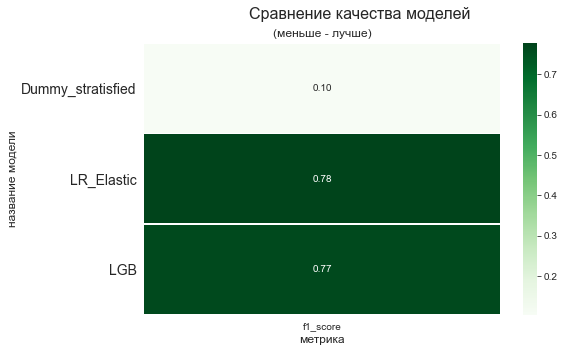

In [82]:
plt.figure(figsize=(8, 5))
scaled_df = (df_model_result - df_model_result.min(axis=0))/(df_model_result.max(axis=0) - df_model_result.min(axis=0))
sns.heatmap(df_model_result, annot=df_model_result, fmt='.2f', linewidths=.5, cmap="Greens")
plt.suptitle('Cравнение качества моделей', fontsize=16)
plt.yticks(rotation=0, fontsize=14)
plt.ylabel('название модели', fontsize=12)
plt.xlabel('метрика', fontsize=12)
plt.title('(меньше - лучше)', fontsize=12);

**ВЫВОД**\
**Лучшее качество дала модель**\
Обычная **линейная регрессия полность удовлетворяет требованиям проекта, результат на тестовой выборке F1=0.78**, LightGBM дала чуть худший результат - 0,77, если сделать корректировку при округлении полученного коэффециента класса +0.1 это даст f1 - до 0.78.\
Для ускорения вычислений и снижения требований к объему памяти модель BERT обучалась в урезанном виде (ограничение текста до 128 слов). Но при достижении 86% обучения постоянно возникает ошибка недостатка памяти. Пути улучшения модели: увеличение длины текста для векторизации до максимального - 512 слов, и возможно сочетанием выборки слов с начала и с конца текста (в исполненном варианте все слова взяты от начала текста) 

cv:

https://habr.com/ru/company/mipt/blog/450732/

https://www.youtube.com/channel/UCQj_dwbIydi588xrfjWSL5g

https://habr.com/ru/company/smartengines/blog/499566/